# Galaxy Image Classification 

This model was created to offer astronomers additional help in classifying galaxies so they don't have to manually look at all the photographic plates. Most models out there offer high accuracies but may not be the easiest to implement, I will try to make a user friendly model. 

### Column Descriptions

**training_predictions**: Probability distributions for the classifications for each of the training images.

**images_test**: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. (I don't use this)

**images_train**: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

### Importing Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm #displays progress bar within for loops
import matplotlib.pyplot as plt
from skimage import io
import pickle
from skimage.transform import resize
import glob
import os
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
from keras import regularizers, optimizers 

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


### Size of all images

```python
size = set()
for filename in glob.glob('data/*.jpg'): 
    im=io.imread(filename).shape
    size.add(im)``` 

size for all images are: {(424, 424, 3)}

### Visualizing some of the training data

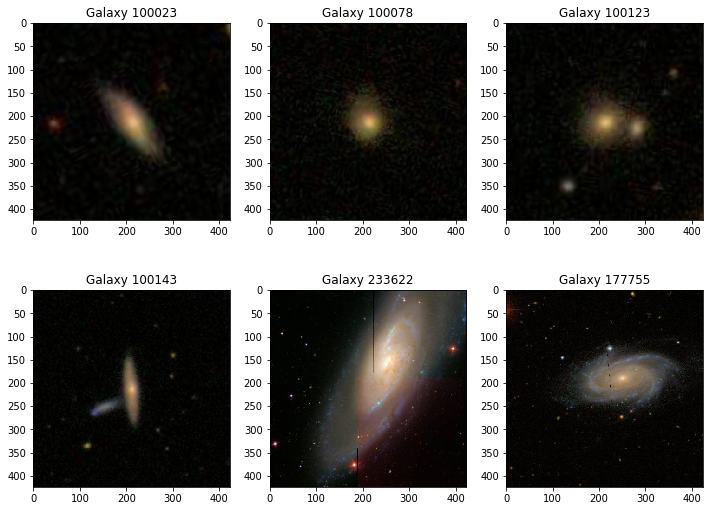

<Figure size 432x288 with 0 Axes>

In [2]:
#Let's look at four of our galaxies from the 61578 images in our training set. 

plt.figure(1, figsize=(12,9))
plt.subplot(231)
plt.imshow(plt.imread('data/train/spiral/100023.jpg'))
plt.title('Galaxy 100023')

plt.subplot(232)
plt.imshow(plt.imread('data/train/elliptical/100078.jpg'))
plt.title('Galaxy 100078')

plt.subplot(233)
plt.imshow(plt.imread('data/train/elliptical/100123.jpg'))
plt.title('Galaxy 100123')

plt.subplot(234)
plt.imshow(plt.imread('data/train/spiral/100143.jpg'))
plt.title('Galaxy 100143')

plt.subplot(235)
plt.imshow(plt.imread('data/train/spiral/233622.jpg'))
plt.title('Galaxy 233622')

plt.subplot(236)
plt.imshow(plt.imread('data/train/spiral/177755.jpg'))
plt.title('Galaxy 177755')

plt.show()
plt.tight_layout()

From the images above, as a scientist I can already tell what morphology these galaxies are of, but now the question is will the computer be able to classify them correctly. Let's first build a baseline model then compare it to a CNN model. 

### Visualize the predictions

In [3]:
import pandas as pd
import numpy as np

predictions = pd.read_csv('predictions.csv')
predictions.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


There seems to be ambigious headings for our columns and the resources on Kaggle don't seem to help much. Essentially, the classes refer to the morphology on the galaxy. 

In [4]:
(predictions['Class1.1'] + predictions['Class1.2'] + predictions['Class1.3']).head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [5]:
predictions = predictions[['GalaxyID','Class1.1', 'Class1.2', 'Class1.3']]
predictions.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
5,100122,0.738832,0.238159,0.023009
6,100123,0.462492,0.456033,0.081475
7,100128,0.687783,0.288344,0.023873
8,100134,0.021834,0.976952,0.001214
9,100143,0.269843,0.730157,0.000000


Based on the images printed above, we can use our physics brain to determine what the columns stand for and rename the columns. 

In [6]:
predictions.columns = ['GalaxyID', 'Elliptical', 'Spiral', 'Irregular']
predictions.head()

,GalaxyID,Elliptical,Spiral,Irregular
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161


If the value in the irregular was the max value for that row, we called it an irregular. 

Note: The following code below no longer works because the irregular folders are deleted. 

```python
print('num in train elliptical = {}'.format(len(os.listdir('data/train/elliptical/'))))
print('num in train spiral = {}'.format(len(os.listdir('data/train/spiral/'))))
print('num in train irregular = {}'.format(len(os.listdir('data/train/irregular/'))))
print('num in test elliptical = {}'.format(len(os.listdir('data/test/elliptical/'))))
print('num in test spiral = {}'.format(len(os.listdir('data/test/spiral/'))))
print('num in test irregular = {}'.format(len(os.listdir('data/test/irregular/'))))```

num in train elliptical = 13237 <br>
num in train spiral = 17526 <br>
num in train irregular = 26 <br>
num in test elliptical = 13456 <br>
num in test spiral = 17300 <br>
num in test irregular = 33 <br>

For this, we can remove the irregular images since they make such a small portion of our over all dataset. 

Now, let's delete the irregular galaxies from the predictions (because we deleted their images). Then we will drop the "Irregular" column.

In [7]:
len(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)])

59

In [8]:
predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].head()

,GalaxyID,Elliptical,Spiral,Irregular
1791,126783,0.178000,0.044000,0.778000
2376,135453,0.360342,0.098619,0.541039
6957,202788,0.242413,0.290022,0.467565
7434,209411,0.273749,0.202910,0.523342
7557,211113,0.289000,0.133000,0.578000


In [9]:
predictions.drop(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].index,inplace=True)

In [10]:
predictions.drop(['Irregular'], axis=1, inplace=True)

In [11]:
predictions.head()

,GalaxyID,Elliptical,Spiral
0,100008,0.383147,0.616853
1,100023,0.327001,0.663777
2,100053,0.765717,0.177352
3,100078,0.693377,0.238564
4,100090,0.933839,0.000000


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from keras.layers import Dropout 
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [20]:
# get all the data in the directory split/test, and reshape them
datagen = ImageDataGenerator(rescale=1./255)
data_tr=datagen.flow_from_directory(
        'data/train', 
        target_size=(106, 106), #actual image size 
        batch_size = 10000,
        class_mode='binary',
        seed = 123)

Found 30763 images belonging to 2 classes.


In [21]:
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        'data/test', 
        target_size=(106, 106), 
        batch_size = 10000, 
        class_mode='binary',
        seed = 123) 

Found 30756 images belonging to 2 classes.


In [22]:
x_tr, y_tr=  next(data_tr)
x_te, y_te =  next(data_te)

In [23]:
y_tr[:5]

array([1., 1., 0., 0., 1.], dtype=float32)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.20, random_state=123)


In [25]:
len(x_te)

10000

In [26]:
X_val.shape

(2000, 106, 106, 3)

### CNN Model Architecture

In [28]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.1), input_shape=(106, 106,  3), padding='valid',strides=(2,2)))
cnn.add(layers.Conv2D(64, (3, 3), input_shape=(106, 106,  3), padding='valid',strides=(2,2)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(0.5))
cnn.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.1)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())

cnn.add(layers.Dense(128))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))

cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))        
        

# decay_rate = learning_rate / epochs
sgd = optimizers.SGD(lr=0.01, decay=0.0002, momentum=0.9, nesterov=False)
cnn.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['acc'])
        

In [29]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 52, 52, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        36928     
__________

`cnn1` is the history of the loss / accuracy

In [30]:
# X_train, X_val, y_train, y_val

cnn1 = cnn.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=500)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 22s 3ms/step - loss: 6.8717 - acc: 0.6070 - val_loss: 5.4816 - val_acc: 0.6475
Epoch 2/50
8000/8000 [==============================] - 21s 3ms/step - loss: 4.2665 - acc: 0.6939 - val_loss: 3.0938 - val_acc: 0.7035
Epoch 3/50
8000/8000 [==============================] - 21s 3ms/step - loss: 2.3439 - acc: 0.7321 - val_loss: 1.8458 - val_acc: 0.5815
Epoch 4/50
8000/8000 [==============================] - 21s 3ms/step - loss: 1.3431 - acc: 0.7504 - val_loss: 1.1246 - val_acc: 0.7225
Epoch 5/50
8000/8000 [==============================] - 21s 3ms/step - loss: 0.8849 - acc: 0.7646 - val_loss: 0.9348 - val_acc: 0.5355
Epoch 6/50
8000/8000 [==============================] - 21s 3ms/step - loss: 0.6867 - acc: 0.7716 - val_loss: 0.8466 - val_acc: 0.4695
Epoch 7/50
8000/8000 [==============================] - 21s 3ms/step - loss: 0.6022 - acc: 0.7834 - val_loss: 0.9560 - val_acc: 0.4190
Epoch 8

In [31]:
cnn.save('cnn11_only_lr.h5')

In [32]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 52, 52, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        36928     
__________

## Confusion Matrix 

In [33]:
cnn.evaluate(X_train, y_train)

8000/8000 [==============================] - 4s 531us/step


[0.5746020286083221, 0.79625]

In [34]:
predictions = cnn.predict(x_te)
predictions = np.around(predictions)

In [35]:
f1_score(y_te, predictions, average='macro')

0.7676284553200616

We obviously overfit during the training run, which is what we wanted to make sure our model 
is ok. The testing result was ok. Now let's improve. 

In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[2820 1518]
 [ 699 4963]]


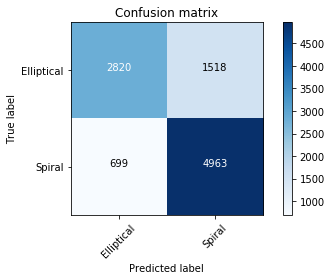

In [37]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_te, predictions), classes=['Elliptical', 'Spiral'])

#The confusion matrix shows that the model performs well on classifying spirals but not so much 
#ellipticals. 

In [38]:
def predictoneimage_cnn(cnn, path):
    img = load_img(path, target_size=(106, 106))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = cnn.predict(img)
    return predict 

#### Keras' flow_from_directory method orders folder structure alphabetical, elliptical is first, and 0 is first. So, 0 is elliptical and 1 is spiral. 

array([[0.08806449]], dtype=float32)

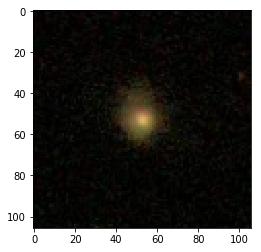

In [42]:
predictoneimage_cnn(cnn, 'data/train/elliptical/100078.jpg') 

array([[0.28784153]], dtype=float32)

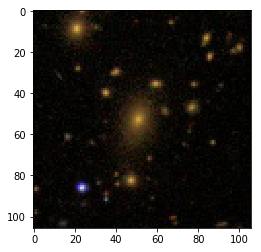

In [43]:
predictoneimage_cnn(cnn, 'data/test/elliptical/564639.jpg')

### Decision Tree  

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_model = DecisionTreeClassifier() 

In [ ]:
x_tr.shape

In [ ]:
y_tr.shape

In [ ]:
y_tr

In [ ]:
y_df = pd.DataFrame.from_records(y_tr)
y_df.head()

We want to throw away column "1" because the two columns are redundant. If the first value is zero, the second value **has** to be one. If the first value is one, the second values has to be zero. 

10000 = number of images
160*160*3 = 11236 = number of pixels 

In [ ]:
x_tr_flat = x_tr.reshape((10000,x_tr.shape[1]*x_tr.shape[2]*x_tr.shape[3]))

In [ ]:
tree_model.fit(x_tr_flat, y_tr)

In [ ]:
x_te_flat = x_te.reshape((10000,x_te.shape[1]*x_te.shape[2]*x_te.shape[3]))

In [ ]:
y_predict = tree_model.predict(x_te_flat)

In [ ]:
accuracy_score(y_te, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te.argmax(axis=1), y_predict.argmax(axis=1))

### Inception

In [ ]:
#we can use any of the inception stuff even if they are trained on anything
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [ ]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(2,activation='sigmoid')) #final layer with softmax activation

In [ ]:
for i,layer in enumerate(imagenet.layers):
    print(i,layer.name, layer.trainable)

In [ ]:
#don't train the image net (or you will wait too long which is the first layer)
for layer in new_model.layers[:1]:
    layer.trainable=False

In [ ]:

new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
new_model.fit(x_tr,
          y_tr,
          epochs=200,
          batch_size=50,
          validation_data=(x_val, y_val))

In [ ]:
new_model.evaluate(x_te, y_te)

In [ ]:
predictions_transfer = new_model.predict(x_te)
predictions_transfer = np.around(predictions_transfer)

In [ ]:
f1_score(y_te, predictions_transfer, average='macro') 